# TSP (巡回セールスマン問題)

ここでは、[[Andrew Lucas, 2013]](https://arxiv.org/abs/1302.5843) に沿って TSP をイジング模型で定式化し、シミュレーティッドアニーリングと量子アニーリングで解いてみます。

In [1]:
%matplotlib inline

import collections
import time

import matplotlib.pyplot as plt
import numpy as np

import anneal
from anneal.models import ClassicalIsingModel, QuantumIsingModel
from anneal.annealers import SimulatedAnnealer, QuantumAnnealer

まずは、距離関数と各種重みを構築する関数を定義します。

In [2]:
POSITIONS = np.array((
    (24050.0000, 123783),
    (24216.6667, 123933),
    (24233.3333, 123950),
    (24233.3333, 124016),
    (24250.0000, 123866),
    (24300.0000, 123683),
    (24316.6667, 123900),
    (24316.6667, 124083),
    (24333.3333, 123733),
))

In [3]:
def dist(a, b):
    a = np.array(a)
    b = np.array(b)
    return np.sqrt(((a - b)**2).sum())

def build_weights(positions, coeff=1):
    n_cities = len(positions)

    j = collections.defaultdict(int)
    max_dist = 0
    for t in range(n_cities):
        for a in range(n_cities):
            for b in range(n_cities):
                d = dist(positions[a], positions[b])
                max_dist = d if max_dist < d else max_dist
                j[t, a, (t + 1)%n_cities, b] = -d

    A = max_dist * coeff
    for t in range(n_cities):
        for a in range(n_cities):
            for b in range(n_cities):
                if a != b:
                    j[t, a, t, b] -= 2*A

    for a in range(n_cities):
        for t1 in range(n_cities):
            for t2 in range(n_cities):
                if t1 != t2:
                    j[t1, a, t2, a] -= 2*A

    h = np.zeros((n_cities, n_cities))
    for t in range(n_cities):
        for a in range(n_cities):
            h[t, a] += 2*A

    c = -2*A*n_cities
    return j, h, c

進捗の可視化のため、コールバック関数を定義しておきます。

In [4]:
class Callback(object):
    def __init__(self):
        self.history = []
        
    def __call__(self, annealer, state_is_updated, model_is_updated):
        objective_value = annealer.model.objective_value()
        self.history.append(objective_value)
        if annealer.iter_count % 1 == 0:
            if isinstance(annealer.model, QuantumIsingModel):
                state = annealer.model.observe_best()
            else:
                state = annealer.model.state
            print("{}: {}'th iter, beta: {}, gamma: {}, objective_value: {}, is_valid: {}".format(
                annealer.__class__.__name__,
                annealer.iter_count,
                annealer.model.beta,
                annealer.model.__dict__.get('gamma', 0),
                objective_value,
                self.check_constraints(state)
            ))
            
    def check_constraints(self, state):
        return (
            (state.to_array().sum(axis=1) == 1).all()
            and (state.to_array().sum(axis=0) == 1).all()
        )


In [5]:
j, h, c = build_weights(POSITIONS)

## シミュレーティッドアニーリングの実施
シミュレーティッドアニーリングを実施します。<br>
初期値をランダムに変えて16回繰り返し、最適なものを採用します。

In [6]:
c_history = []
min_energy = float('inf')
best_annealer = None
iter = 0
start = time.time()
for i in range(16):
    print('{}th challenge.'.format(i))
    callback = Callback()
    c_model = ClassicalIsingModel(j, h, c,  state_shape=h.shape)
    c_annealer = SimulatedAnnealer(c_model, beta_factor=2)  # max_iter が小さいので、 beta_factor は大きく取っている
    c_annealer.anneal(iter_callback=callback, max_iter=10)
    c_history.append(callback.history)
    energy = c_model.objective_value()
    iter += c_annealer.iter_count
    if energy < min_energy:
        min_energy = energy
        best_annealer = c_annealer

best_model = best_annealer.model
print('annealing time: {}'.format(time.time() - start))
print('annealer: {}'.format(best_annealer))
print('iterations(average): {}'.format(iter/16))
print('objective: {}'.format(best_model.objective_value()))
print('state: {}'.format(best_model.state.to_array()))

0th challenge.
SimulatedAnnealer: 1'th iter, beta: 0.2, gamma: 0, objective_value: 2512.8397443882095, is_valid: False
SimulatedAnnealer: 2'th iter, beta: 0.4, gamma: 0, objective_value: 1605.0628322724588, is_valid: True
SimulatedAnnealer: 3'th iter, beta: 0.8, gamma: 0, objective_value: 1605.0628322724588, is_valid: True
SimulatedAnnealer: 4'th iter, beta: 1.6, gamma: 0, objective_value: 1605.0628322724588, is_valid: True
SimulatedAnnealer: 5'th iter, beta: 3.2, gamma: 0, objective_value: 1605.0628322724588, is_valid: True
SimulatedAnnealer: 6'th iter, beta: 6.4, gamma: 0, objective_value: 1605.0628322724588, is_valid: True
SimulatedAnnealer: 7'th iter, beta: 12.8, gamma: 0, objective_value: 1605.0628322724588, is_valid: True
SimulatedAnnealer: 8'th iter, beta: 25.6, gamma: 0, objective_value: 1605.0628322724588, is_valid: True
SimulatedAnnealer: 9'th iter, beta: 51.2, gamma: 0, objective_value: 1605.0628322724588, is_valid: True
SimulatedAnnealer: 10'th iter, beta: 102.4, gamma: 0, 

## 量子アニーリングの実施
量子アニーリングを実施します。<br>
シミュレーティッドアニーリングに合わせて、 トロッタ数(並列数)を16とします。

In [7]:
start = time.time()
callback = Callback()
q_model = QuantumIsingModel(j, h, c, state_shape=h.shape, n_trotter=100) 
q_annealer = QuantumAnnealer(q_model, gamma_factor=0.5)  # max_iter が小さいので、 gamma_factor は小さく取っている
q_annealer.anneal(iter_callback=callback, max_iter=10)
observed = q_model.observe_best()
print('annealing time: {}'.format(time.time() - start))
print('annealer: {}'.format(q_annealer))
print('iterations: {}'.format(q_annealer.iter_count))
print('objective: {}'.format(q_model.objective_value()))
print('best state: {}'.format(observed.to_array()))
print('energy of observed: {}'.format(c_model.energy(observed)))

QuantumAnnealer: 1'th iter, beta: 100.0, gamma: 0.5, objective_value: 1791.063435215532, is_valid: False
QuantumAnnealer: 2'th iter, beta: 100.0, gamma: 0.25, objective_value: 1253.302610491166, is_valid: True
QuantumAnnealer: 3'th iter, beta: 100.0, gamma: 0.125, objective_value: 1253.302610491166, is_valid: True
QuantumAnnealer: 4'th iter, beta: 100.0, gamma: 0.0625, objective_value: 1253.302610491166, is_valid: True
QuantumAnnealer: 5'th iter, beta: 100.0, gamma: 0.03125, objective_value: 1253.302610491166, is_valid: True
QuantumAnnealer: 6'th iter, beta: 100.0, gamma: 0.015625, objective_value: 1253.302610491166, is_valid: True
QuantumAnnealer: 7'th iter, beta: 100.0, gamma: 0.0078125, objective_value: 1253.302610491166, is_valid: True
QuantumAnnealer: 8'th iter, beta: 100.0, gamma: 0.00390625, objective_value: 1253.302610491166, is_valid: True
QuantumAnnealer: 9'th iter, beta: 100.0, gamma: 0.001953125, objective_value: 1253.302610491166, is_valid: True
QuantumAnnealer: 10'th iter

In [8]:
def plot_route(state, positions):
    route = [positions[np.argmax(row)] for row in state.to_array()]
    route.append(route[0])
    route = np.array(route)
    
    d = 0
    for i in range(1, len(route)):
        d += dist(route[i - 1], route[i])
    print(d)
    plt.plot(route[:, 0], route[:, 1], '-o')

Simulated Annealing
1408.62640435


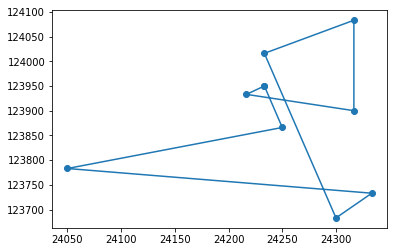

Quantum Annealing
1253.30261049


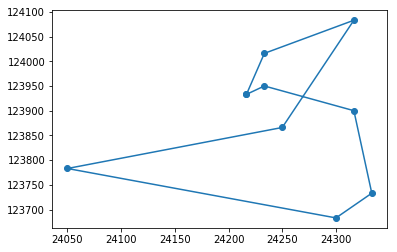

In [9]:
print('Simulated Annealing')
plot_route(best_model.state, POSITIONS)
plt.show()
print('Quantum Annealing')
plot_route(observed, POSITIONS)
plt.show()